# MNIST Dataset - Handwritten Digits Recognition

**The objective of this study is to perform image recognition on handwritten digits.**

**We will be answering the following questions :**
- What is the best performing model ? 
- Will the models recognize our own hadwriting ? 
- What is the best model to generate new data ?
- Will you be able to distinguish fake from real data ?

**List of algorithms that we will compare :**
- Linear Classifier 
- KNN
- SVMs
- Neural Nets 
- Convolutional Neural Nets
- GAN / VAE


+nos chiffres

## Import the data

In [ ]:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz

In [ ]:
!gunzip t*-ubyte.gz

In [ ]:
#!pip install mlxtend

In [1]:
from mlxtend.data import loadlocal_mnist
import numpy as np
import matplotlib.pyplot as plt

import os

In [2]:
os.getcwd()

'/Users/victor/Desktop/MNIST-Handwritten-digits-recognition-'

In [3]:
X_train, y_train = loadlocal_mnist(
        images_path='data/train-images-idx3-ubyte', 
        labels_path='data/train-labels-idx1-ubyte')

X_test, y_test = loadlocal_mnist(images_path = 'data/t10k-images-idx3-ubyte', 
                                labels_path = 'data/t10k-labels-idx1-ubyte')

In [ ]:
print('Dimensions: %s x %s' % (X_train.shape[0], X_train.shape[1]))
print('\n1st row', X_train[0])

In [ ]:
print('Digits:  0 1 2 3 4 5 6 7 8 9')
print('labels: %s' % np.unique(y_train))
print('Class distribution: %s' % np.bincount(y_train))

In [ ]:
plt.hist(y_train)

In [ ]:
X_train.shape
y_train.shape

In [ ]:
#Store as CSV files
np.savetxt(fname='images_train.csv', 
           X=X_train, delimiter=',', fmt='%d')
np.savetxt(fname='labels_train.csv', 
           X=y_train, delimiter=',', fmt='%d')

In [ ]:
np.savetxt(fname='images_test.csv', 
           X=X_test, delimiter=',', fmt='%d')
np.savetxt(fname='labels_test.csv', 
           X=y_test, delimiter=',', fmt='%d')

In [ ]:
#Show first digit 
pixels = X_train[5].reshape((28,28))
plt.imshow(pixels, cmap = 'Greys')

In [ ]:
pixels = X_train[1].reshape((28,28))
plt.imshow(pixels, cmap = 'Greys')

In [ ]:
pixels = X_train[3].reshape((28,28))
plt.imshow(pixels, cmap = 'Greys')

## Reshaping and Normalizing the images

In [ ]:
#https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d
# Reshaping the array to 4-dims so that it can work with the Keras API
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print('Number of images in X_train', X_train.shape[0])
print('Number of images in X_test', X_test.shape[0])

## CNN

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adadelta

In [ ]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))



In [ ]:
model.compile(optimizer="Adadelta",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(x=X_train,y=y_train, epochs=5)

In [ ]:
model.evaluate(X_test, y_test)

Prediction error : 98,5%


In [ ]:
image_index = 222
plt.imshow(X_test[image_index].reshape(28, 28),cmap='Greys')

In [ ]:
pred = model.predict(X_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

## Linear Classifier

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd

In [ ]:
X_train = pd.read_csv("images_train.csv")
y_train = pd.read_csv("labels_train.csv")
X_test = pd.read_csv("images_test.csv")
y_test = pd.read_csv("labels_test.csv")

In [ ]:
X_train.describe()

In [ ]:
param_grid = {"C" : [0.1], "gamma" : [0.1]}
lc = LinearSVC()
grid = GridSearchCV(estimator=lc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1, verbose=1)
lc = lc.fit(X_train, y_train)

In [ ]:
lc.predict(X_test)
lc.score(X_test, y_test)

## SVM

**To do** : With some classification methods (particuarly template-based methods, such as SVM and K-nearest neighbors), the error rate improves when the digits are centered by bounding box rather than center of mass.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [10]:
train_images = pd.read_csv("images_train.csv")
test_images = pd.read_csv("images_test.csv")
train_labels = pd.read_csv("labels_train.csv")
test_labels = pd.read_csv("labels_test.csv")

In [ ]:
sns.countplot(train_labels["5"])

In [ ]:
sns.countplot(test_labels["7"])

In [15]:
parameters = {'SVM__C':[0.001, 0.1, 100, 10e5], 'SVM__gamma':[10,1,0.1,0.01]} #Decide on the value of C and gamma
steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel='poly'))]
pipeline = Pipeline(steps) # define Pipeline object
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [14]:
train_labels = train_labels["5"]

In [ ]:
grid.fit(train_images, train_labels)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Library/Frameworks/Python.framework/

## K Nearest Neighbors

In [ ]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
#import imutils
import cv2
import matplotlib.pyplot as plt

images_train, labels_train = X_train, y_train 

images_test, labels_test = X_test, y_test 


In [ ]:
# now, let's take 10% of the training data and use that for validation

(images_train1, valData, labels_train1, valLabels) = train_test_split(images_train, labels_train,
test_size=0.1, random_state=84)

# show the sizes of each data split

print("training data points: {}".format(len(images_train1)))
print("validation data points: {}".format(len(valLabels)))
print("testing data points: {}".format(len(labels_test)))

In [ ]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k

kVals = range(1, 30, 2)
accuracies = []

# loop over various values of `k` for the k-Nearest Neighbor classifier

for k in range(1, 20, 2):
          # train the k-Nearest Neighbor classifier with the current value of `k`
          model = KNeighborsClassifier(n_neighbors=k)
          model.fit(images_train1, labels_train1)
          # evaluate the model and update the accuracies list
          score = model.score(valData, valLabels)
          print("k=%d, accuracy=%.2f%%" % (k, score * 100))
          accuracies.append(score)
        

i = np.argmax(accuracies)
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i],
accuracies[i] * 100))

In [ ]:
# re-train our classifier using the best k value and predict the labels of the
# test data

model = KNeighborsClassifier(n_neighbors=kVals[i])
model.fit(images_train, labels_train)
predictions = model.predict(images_test)
#print(predictions[1])

In [ ]:
# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits

print("EVALUATION ON TESTING DATA")
print(classification_report(labels_test, predictions))

## Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
X_train = X_train.reshape([60000, 28, 28])
X_train.shape

In [ ]:
len(y_train)

In [ ]:
X_test = X_test.reshape([10000, 28, 28])
X_test.shape

In [ ]:
len(y_test)

In [ ]:
#Build a network with a sequence of two layers. The first dense has 128 nodes and the second dense 
#is a 10-node softwmax layer : it returns 10 probability scores that sum to 1. They correspond to 
#the probability that the image belongs to the class. 

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28))
])

d1 = keras.layers.Dense(128, activation=tf.nn.relu)
d_class = keras.layers.Dense(10, activation=tf.nn.softmax)

model.add(d1)
model.add(d_class)


In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs = 5)

In [ ]:
(test_loss, test_acc) = model.evaluate(X_test, y_test)
print("Test accuracy :", test_acc)

#### Optimize the algorithm : 

In [ ]:
#Change network depth 
def create_dense(layer_sizes):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28,28))
    ])
    
    d1 = keras.layers.Dense(layer_sizes[0], activation=tf.nn.relu)
    model.add(d1)

    for s in layer_sizes[1:]:
        d = keras.layers.Dense(units = s, activation = tf.nn.relu)
        model.add(d)

    d_class = keras.layers.Dense(units=10, activation=tf.nn.softmax)
    model.add(d_class)
    return model

In [ ]:
#Evaluate the model 
def evaluate(model, epochs=5):
    model.summary()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=.1, verbose=False)
    loss, accuracy  = model.evaluate(X_test, y_test, verbose=False)
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    print()
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

In [ ]:
for layers in range(1, 5):
    model = create_dense([128] * layers)
    evaluate(model, epochs = 3)

Adding too many layers overfit the model. The best accurarcy is obtained with only one layer in the neural network. With more layers, the neural network fits the training data too precisely, and no longer generalized to data from outside the training set (here, to X_test). Especially with 5 hidden layers we can see that the training accuracy is way larger than the test accuracy, which is an indicator for overfitting. 

In [ ]:
#Change layer width
for nodes in [32, 64, 128, 256, 512, 1024, 2048]:
    model = create_dense([nodes])
    evaluate(model)

More nodes in the hidden layers produce a better performance on the test data. The model reaches the best accuracy with one hidden layer of 2048 nodes. 

In [ ]:
#Final model 

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28))
])

d1 = keras.layers.Dense(2048, activation=tf.nn.relu)
d_class = keras.layers.Dense(10, activation=tf.nn.softmax)

model.add(d1)
model.add(d_class)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train)

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy :", test_acc)

## GAN

In [4]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ['KERAS_BACKEND']='tensorflow'
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

%matplotlib inline

Using TensorFlow backend.


In [5]:
random_dim = 100
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)


def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

Implement the Generator

In [6]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim,
                       kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

And the discriminator

In [7]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784,
                       kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

Train model against each other

In [8]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=(random_dim,))
    x=generator(gan_input)
    gan_output = discriminator(x)
    gan=Model(inputs=gan_input, outputs = gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [9]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28,28)
    
    plt.figure(figsize=figsize)
    
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig('gan_res/gan_generated_image_epoch_'+str(epoch)+'.png')
    #you have to create the repository "gan_res" in "MNIST-Handwritten-digits-recognition-"

In [10]:
def train(epochs=1, batch_size=128):
    
    batch_count = int(X_train.shape[0]/batch_size)
    
    adam = get_optimizer()
    generator = get_generator(adam)
    discrimnator = get_discriminator(adam)
    gan = get_gan_network(discrimnator, random_dim, generator, adam)
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' %e, '-'*15)
        for _ in tqdm_notebook(range(batch_count)):
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            generated_images = generator.predict(noise)
            X=np.concatenate([image_batch, generated_images])
            
            y_dis = np.zeros(2*batch_size)
            
            y_dis[:batch_size] = 0.9
            
            discrimnator.trainable = True
            discrimnator.train_on_batch(X, y_dis)
            
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            
            discrimnator.trainable = False
            gan.train_on_batch(noise, y_gen)
        plot_generated_images(e, generator)

--------------- Epoch 1 ---------------



--------------- Epoch 2 ---------------



--------------- Epoch 3 ---------------



--------------- Epoch 4 ---------------



--------------- Epoch 5 ---------------



--------------- Epoch 6 ---------------



--------------- Epoch 7 ---------------



--------------- Epoch 8 ---------------



--------------- Epoch 9 ---------------



--------------- Epoch 10 ---------------



--------------- Epoch 11 ---------------


KeyboardInterrupt: 

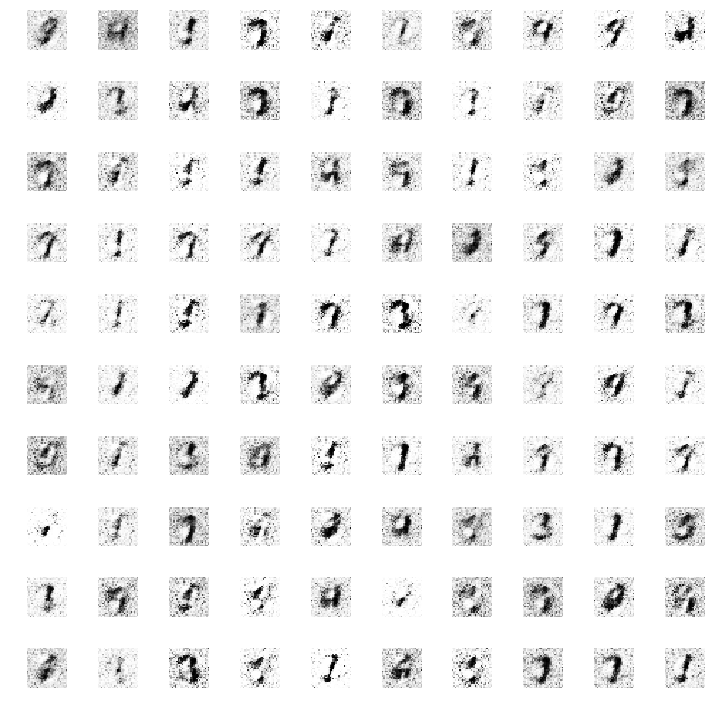

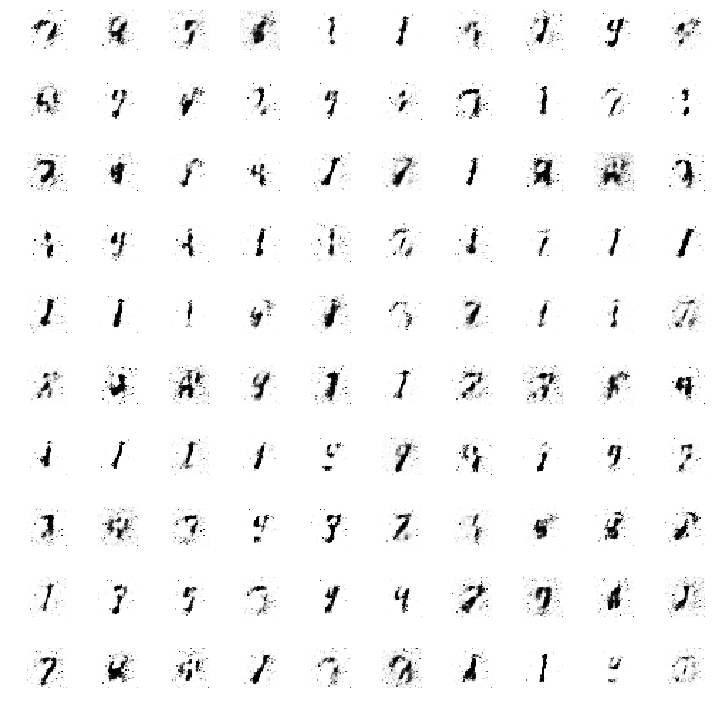

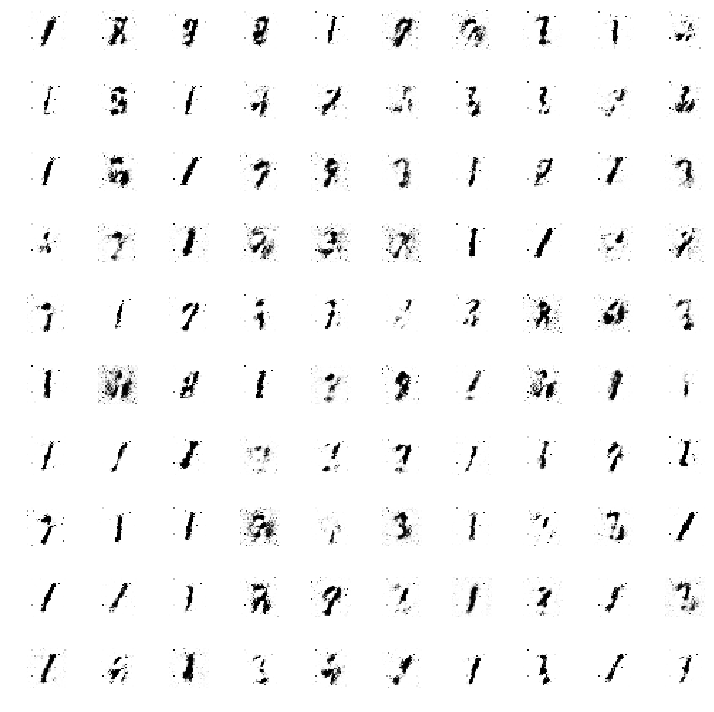

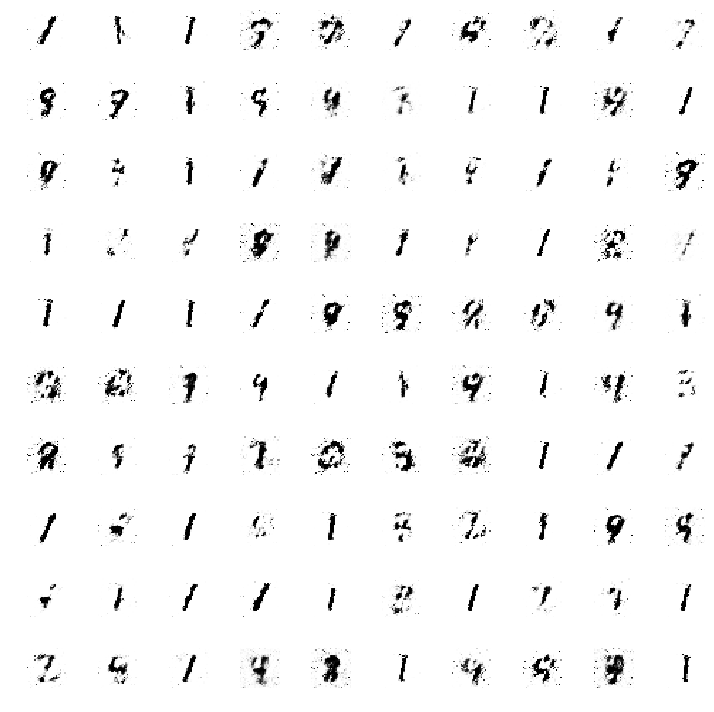

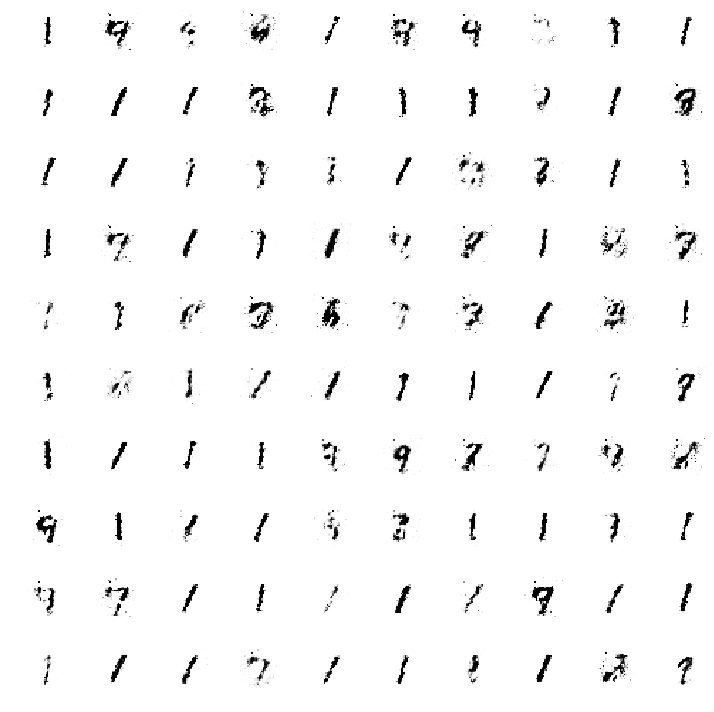

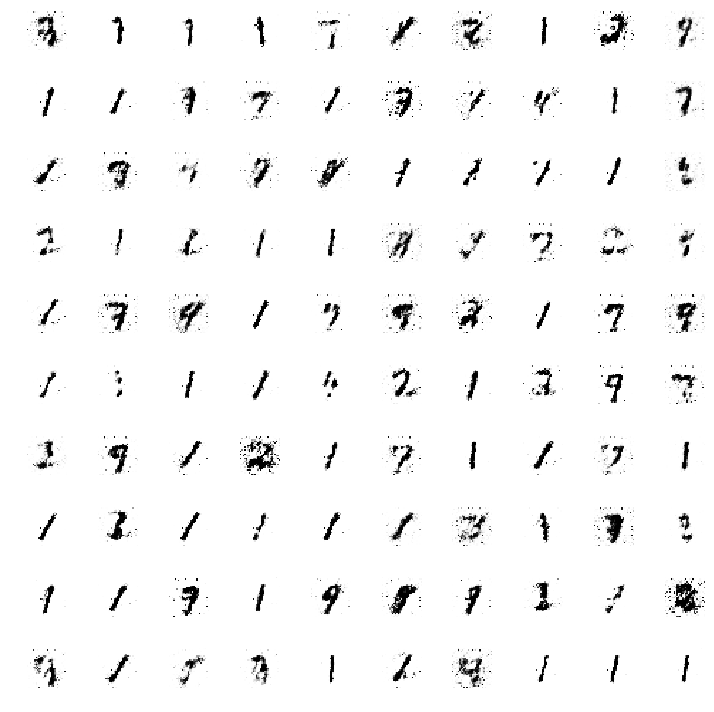

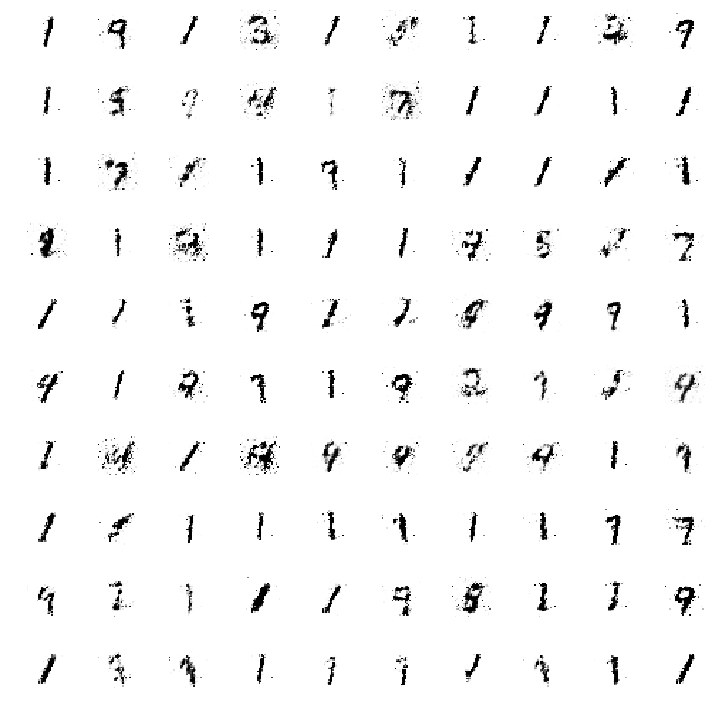

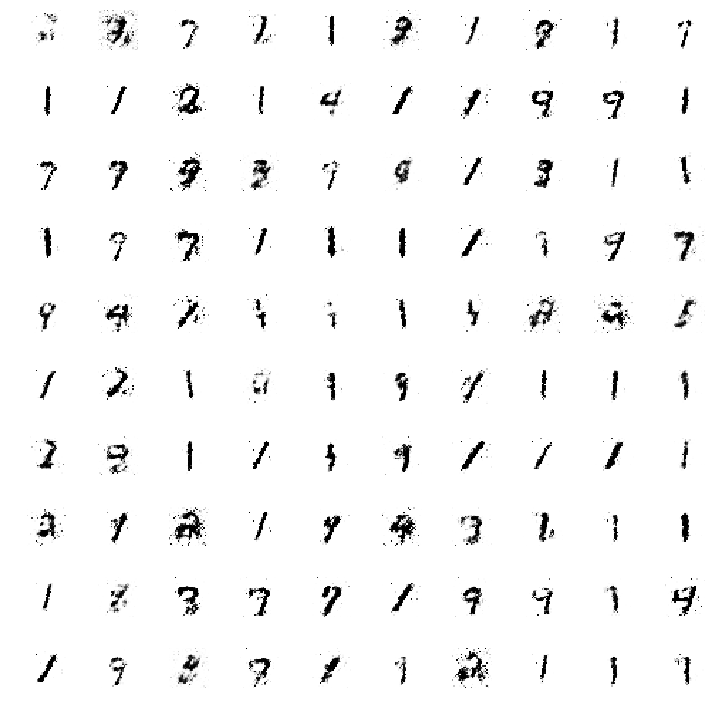

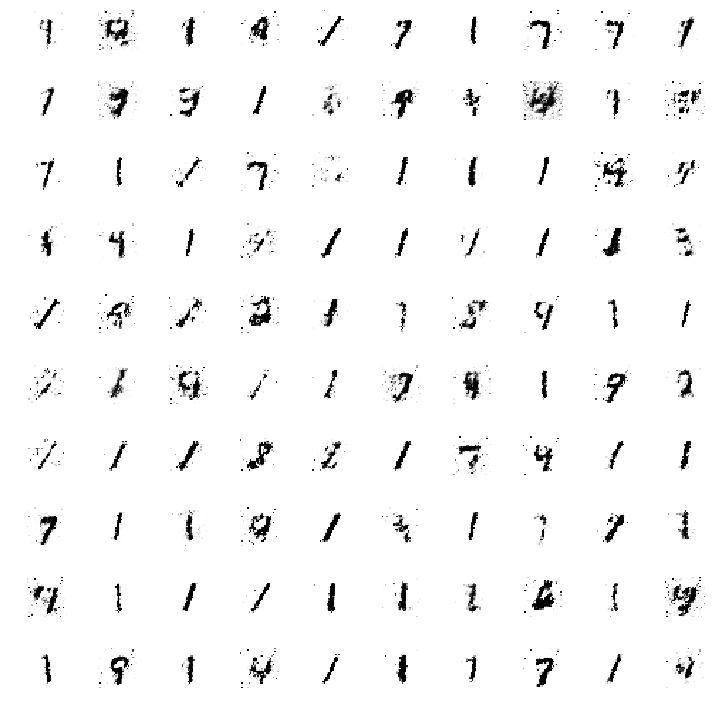

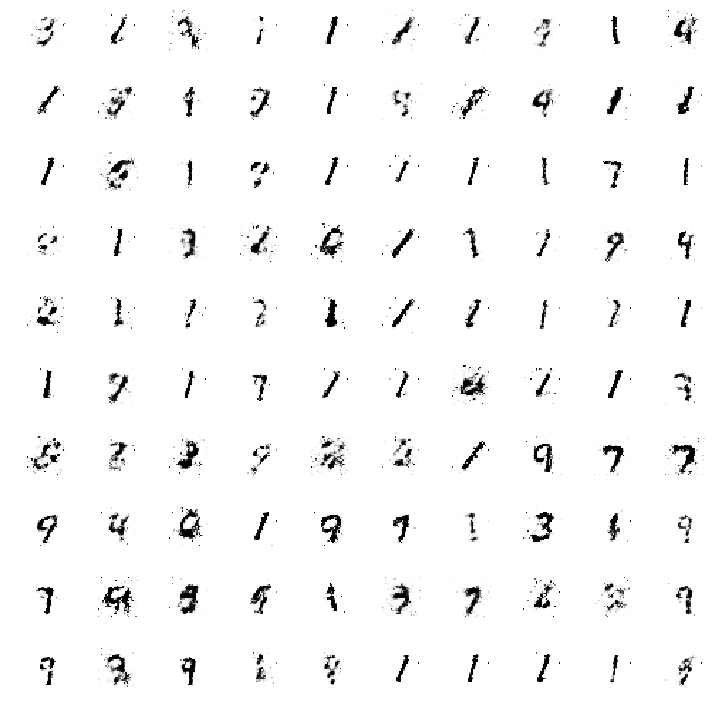

In [11]:
train(20, 128)

VAE 

## Input our own images

In [ ]:
#https://medium.com/@o.kroeger/tensorflow-mnist-and-your-own-handwritten-digits-4d1cd32bbab4